In [2]:
# Connecting through API Key

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
# Download Dataset from kaggle through API (Application Programming Interface)

!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:49<00:00, 23.4MB/s]
100% 1.06G/1.06G [00:50<00:00, 22.9MB/s]


In [4]:
# Extract all folders and files from Zip File

import zipfile
zip_rfe = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_rfe.extractall('/content')
zip_rfe.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/dogs-vs-cats.zip' mode='r'>>

In [5]:
# importing requird libraries

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

In [6]:
# Data augmentation settings for training data
datagen_train = ImageDataGenerator(
    rotation_range=20,         # The range of angles (in degrees) by which to randomly rotate the images.
    width_shift_range=0.2,     # The fraction of the width of the image by which to randomly shift the images horizontally.
    height_shift_range=0.2,    # The fraction of the height of the image by which to randomly shift the images vertically.
    shear_range=0.2,           # he range of shear angles (in degrees) by which to randomly shear the images.
    zoom_range=0.2,            # The range of zoom factors by which to randomly zoom the images.
    horizontal_flip=True,      # Whether to randomly flip the images horizontally.
    fill_mode='nearest',       # The method to use for filling in the gaps created by the augmentations.
    seed=42                    # Set seed for data augmentation and shuffling
    rescale=1.0/255.0          # The factor by which to rescale the images.
)

# Data augmentation settings for training data
datagen_test = ImageDataGenerator(rescale=1.0/255.0)


**Use the seed parameter while creating the training dataset, it ensures that the random processes (like shuffling) applied to the dataset are reproducible across different runs.**

In [7]:
# Create the training data generator

train_ds = datagen_train.flow_from_directory(
    '/content/train',
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'  # or 'categorical' if you have multiple classes
)

# Create the test data generator
validation_ds = datagen_test.flow_from_directory(
    '/content/test',
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'  # or 'categorical' if you have multiple classes
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [8]:
# Check whether train and validation data gets normalized or not?

# Load a batch of normalized training data
train_batch, train_labels = next(train_ds)
print("Normalized Training Data - Min:", np.min(train_batch), "Max:", np.max(train_batch))

# Load a batch of normalized test data
test_batch, test_labels = next(validation_ds)
print("Normalized Test Data - Min:", np.min(test_batch), "Max:", np.max(test_batch))


Normalized Training Data - Min: 0.0 Max: 1.0
Normalized Test Data - Min: 0.0 Max: 1.0


In [9]:
# Checking class labels

train_ds.class_indices , validation_ds.class_indices

({'cats': 0, 'dogs': 1}, {'cats': 0, 'dogs': 1})

# Build CNN Architecture

In [10]:
# Define the model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten the output for fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Regularization by dropout
model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))  # Binary classification output

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     2

**`He_normal` initialization draws random weights from a normal distribution with a mean of 0 and a standard deviation that is calculated based on the number of input and output units in the weight tensor. This helps to prevent the exploding gradients problem and still allows for learning in deep networks.**

**I use he_normal initialization because it is specifically designed for activation functions like ReLU. ReLU activation outputs zero for all negative inputs, which can lead to dead neurons during training if not initialized properly. He_normal initialization helps to prevent the "dying ReLU" problem and facilitates training deep networks effectively.**

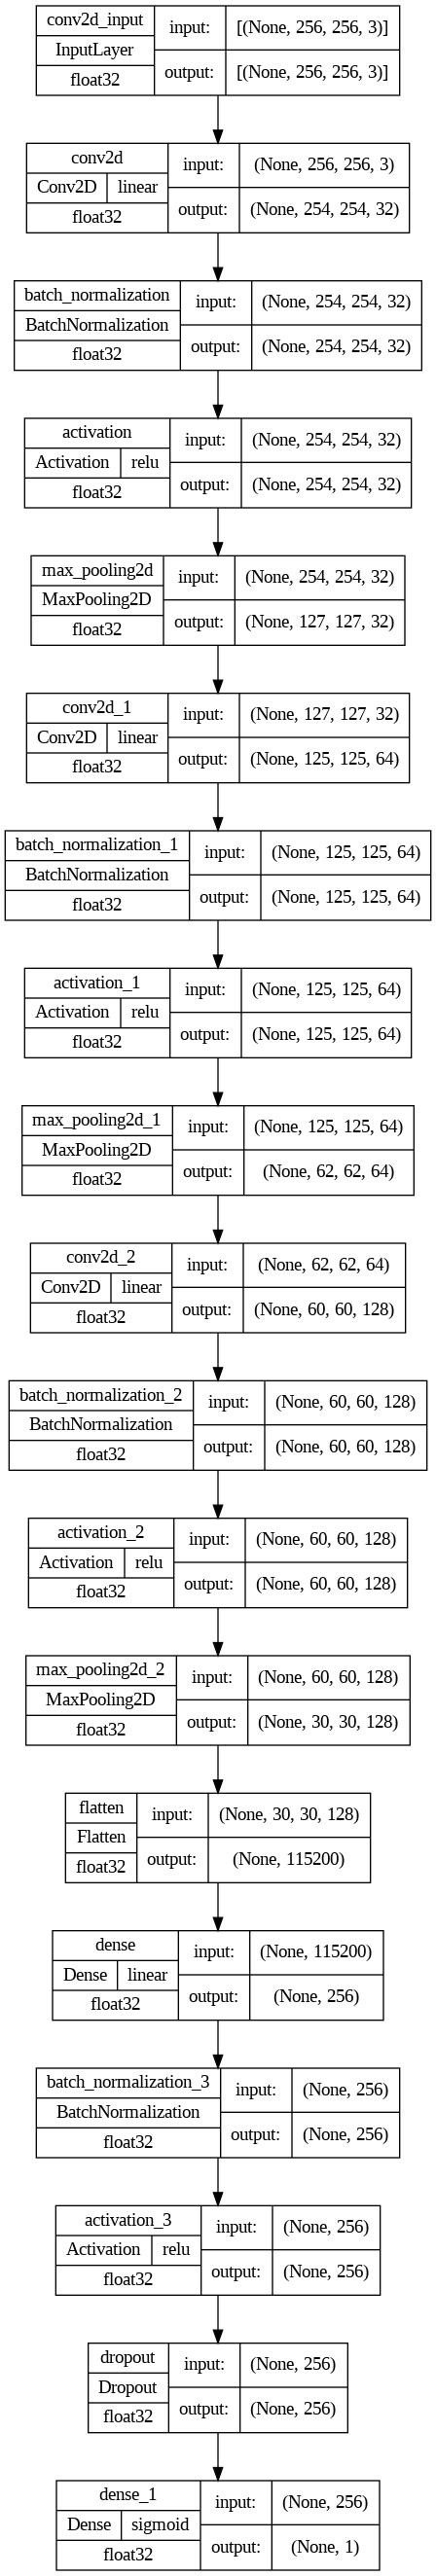

In [28]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [11]:
# creating object for early stopping

early_stopping = EarlyStopping(
    monitor='val_loss',        # The metric to monitor. This is usually the validation loss.
    min_delta=0.001,           # The minimum amount of improvement required to consider the model to have improved.
    patience=3,                # The number of epochs to wait without improvement before stopping the training.
    verbose=1,                 # Print output
    mode='min',                # Consider mode of the metric as min or max.
    restore_best_weights=True  # Whether to restore the model weights at the epoch with the best validation loss.
)

**Early stopping is a technique that stops the training of a model when the validation loss stops improving. If you set restore_best_weights to False, the model will be saved at the end of the training, even if the validation loss has not improved. This could result in the model being saved at a point where it is overfitting the training data. By setting restore_best_weights to True, the model will be saved at the epoch with the best validation loss. This ensures that the model that is saved is the one that is most likely to generalize well to new data.**

**When you set restore_best_weights=True in the EarlyStopping callback, it ensures that the model's weights are restored to the state they were in at the epoch with the lowest validation loss. This means that when you evaluate the model after training, the evaluation metrics, including accuracy and other metrics, are computed based on the weights of the model that performed the best on the validation data.**

In [12]:
# Define a ModelCheckpoint callback to save the best model

checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [13]:
# Fit model on training and validation data

history = model.fit(train_ds, epochs=20, validation_data=validation_ds, batch_size=64, callbacks=[early_stopping, checkpoint])

Epoch 1/20
313/313 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.6585
Epoch 1: val_loss improved from inf to 0.53837, saving model to model_checkpoint.h5
313/313 [==============================] - 360s 1s/step - loss: 0.6537 - accuracy: 0.6585 - val_loss: 0.5384 - val_accuracy: 0.7278
Epoch 2/20
313/313 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.7244
Epoch 2: val_loss did not improve from 0.53837
313/313 [==============================] - 339s 1s/step - loss: 0.5420 - accuracy: 0.7244 - val_loss: 0.6744 - val_accuracy: 0.6238
Epoch 3/20
313/313 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.7509
Epoch 3: val_loss improved from 0.53837 to 0.52082, saving model to model_checkpoint.h5
313/313 [==============================] - 345s 1s/step - loss: 0.5061 - accuracy: 0.7509 - val_loss: 0.5208 - val_accuracy: 0.7608
Epoch 4/20
313/313 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.7675
E

# Plotting Loss and Accuracy of Train and Test Data

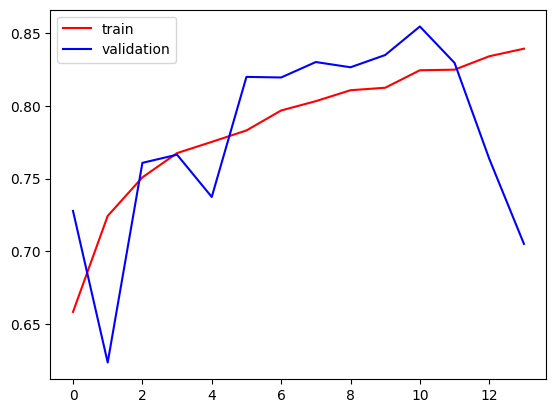

In [14]:
# Plotting graph of training and validation accuracy

import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], color='red', label='train')
plt.plot(history.history["val_accuracy"], color='blue', label='validation')
plt.legend()
plt.show()

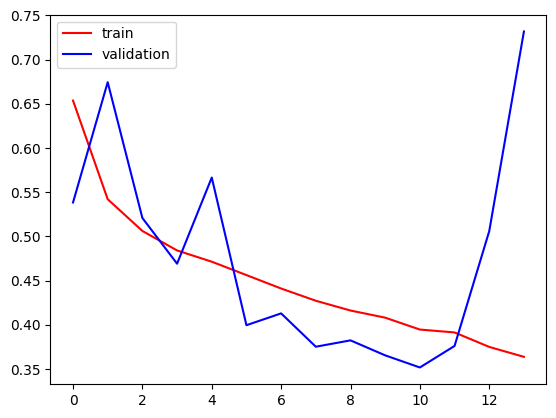

In [15]:
# Plotting graph of training and validation loss

plt.plot(history.history["loss"], color='red', label='train')
plt.plot(history.history["val_loss"], color='blue', label='validation')
plt.legend()
plt.show()

# Model Evaluation

In [16]:
# Evaluate model on the training dataset
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

313/313 [==============================] - 308s 984ms/step - loss: 0.3776 - accuracy: 0.8318
Training Loss: 0.3776
Training Accuracy: 0.8318
79/79 [==============================] - 15s 183ms/step - loss: 0.3517 - accuracy: 0.8544
Validation Loss: 0.3517
Validation Accuracy: 0.8544


# Cat Image Prediction

(300, 219, 3)


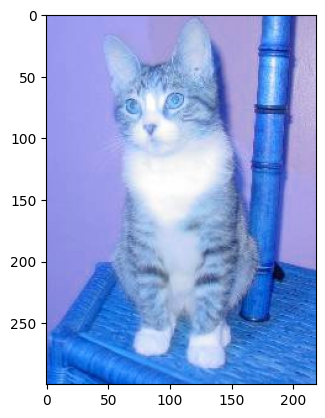

In [74]:
import cv2

cat_test_data = cv2.imread('/content/dogs_vs_cats/test/cats/cat.10007.jpg')
plt.imshow(cat_test_data)
print(cat_test_data.shape)

In [75]:
cat_img_resize = cv2.resize(cat_test_data, (256, 256))  # Resize images to (256x256)
cat_img = cat_img_resize.reshape((1, 256, 256, 3))      # Reshshape images becuase expected input shape of image is (None, 256, 256, 3)

In [76]:
out = model.predict(cat_img)
print(out)
if out>0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 0s 20ms/step
[[2.6229816e-26]]
It's a cat!


# Dog Image Prediction

(374, 500, 3)


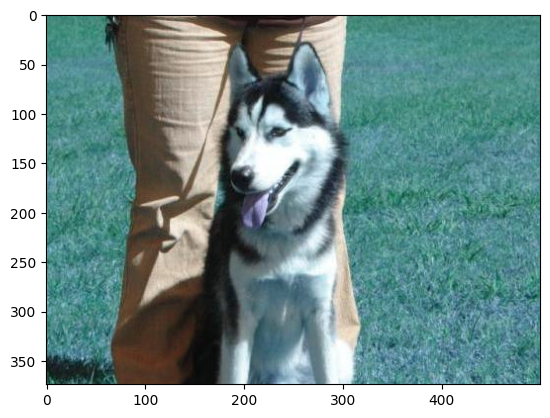

In [84]:
dog_test_data = cv2.imread('/content/dogs_vs_cats/train/dogs/dog.10045.jpg')
plt.imshow(dog_test_data)
print(dog_test_data.shape)

In [85]:
dog_img_resize = cv2.resize(dog_test_data, (256, 256))  # Resize images to (256x256)
dog_img = dog_img_resize.reshape((1, 256, 256, 3))      # Reshshape images becuase expected input shape of image is (None, 256, 256, 3)

In [86]:
out = model.predict(dog_img)
print(out)
if out>0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 0s 32ms/step
[[1.]]
It's a dog!


# Out of time Validation
Out-of-time validation (OTV) is a technique used to evaluate the performance of a machine learning or deep learning model on data that was not seen during training.

(1414, 2121, 3)


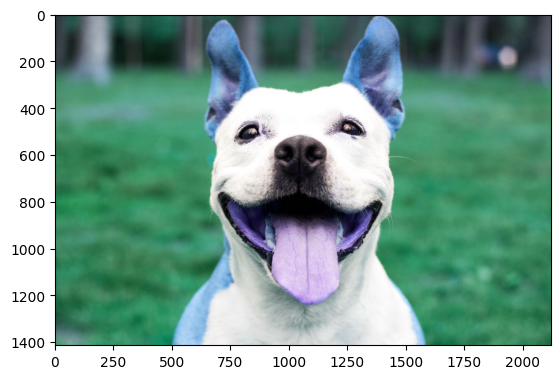

In [94]:
dog_test_data = cv2.imread('/content/The_Science-Backed_Benefits_of_Being_a_Dog_Owner.jpg')
plt.imshow(dog_test_data)
print(dog_test_data.shape)

In [95]:
dog_img_resize = cv2.resize(dog_test_data, (256, 256))  # Resize images to (256x256)
dog_img = dog_img_resize.reshape((1, 256, 256, 3))      # Reshshape images becuase expected input shape of image is (None, 256, 256, 3)

In [96]:
out = model.predict(dog_img)
print(out)
if out>0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 0s 18ms/step
[[1.]]
It's a dog!


(264, 191, 3)


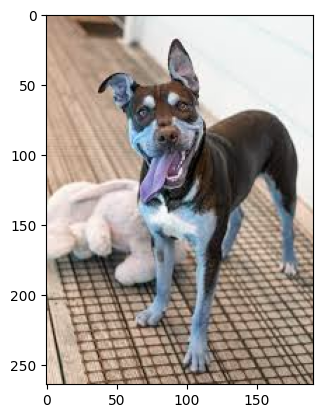

In [87]:
dog_test_data = cv2.imread('/content/images.jpeg')
plt.imshow(dog_test_data)
print(dog_test_data.shape)

In [88]:
dog_img_resize = cv2.resize(dog_test_data, (256, 256))  # Resize images to (256x256)
dog_img = dog_img_resize.reshape((1, 256, 256, 3))      # Reshshape images becuase expected input shape of image is (None, 256, 256, 3)

In [89]:
out = model.predict(dog_img)
print(out)
if out>0.5:
    print("It's a dog!")
else:
    print("It's a cat!")

1/1 [==============================] - 0s 20ms/step
[[1.]]
It's a dog!
